<a href="https://colab.research.google.com/github/saritmaitra/Trading-strategy/blob/master/xgb_trading_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, r2_score
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
import warnings
import seaborn as sns
sns.set()
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
!pip install pyforest
from pyforest import *
import pandas_datareader as web
plt.style.use('ggplot')
!pip install pyfolio
import pyfolio as pf
!pip install backtrader
import backtrader as bt
from backtrader.feeds import PandasData
import warnings

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

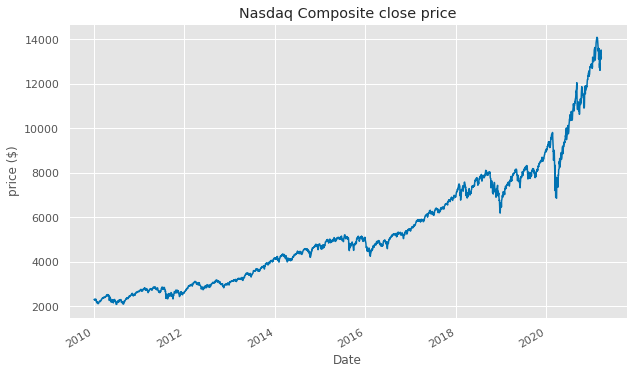

               High      Low     Open    Close      Volume  Adj Close
Date                                                                 
2010-01-04  2311.15  2294.41  2294.41  2308.42  1931380000    2308.42
2010-01-05  2313.73  2295.62  2307.27  2308.71  2367860000    2308.71
2010-01-06  2314.07  2295.68  2307.71  2301.09  2253340000    2301.09
2010-01-07  2301.30  2285.22  2298.09  2300.05  2270050000    2300.05
2010-01-08  2317.60  2290.61  2292.24  2317.17  2145390000    2317.17
...             ...      ...      ...      ...         ...        ...
2021-03-15 13460.35 13272.50 13323.47 13459.71  5933440000   13459.71
2021-03-16 13620.71 13397.08 13523.17 13471.57  5463770000   13471.57
2021-03-17 13595.00 13272.69 13336.91 13525.20  5465500000   13525.20
2021-03-18 13384.46 13101.92 13349.20 13116.17  5699900000   13116.17
2021-03-19 13252.37 13039.45 13119.90 13215.24  7591530000   13215.24

[2822 rows x 6 columns]


In [40]:
def dataExtraction():
  dataset = web.DataReader('^IXIC', data_source = 'yahoo', start = '2010-01-01')
  dataset = dataset.sort_index(ascending=True)
  # display 
  # print(dataset.head()); print(dataset.shape)

  # Plot the closing prices 
  dataset['Adj Close'].plot(grid=True, figsize=(10, 6))
  plt.title('Nasdaq Composite close price')
  plt.ylabel('price ($)')
  # Show the plot
  plt.show()
  return dataset

dataset = dataExtraction()
print(dataset)

### ***Predictors***


In [155]:
def classificationData(dataset):
   dataset['closeGap'] = dataset['Close'].pct_change()
   dataset['highGap'] = dataset['High'].pct_change()
   dataset['lowGap'] = dataset['Low'].pct_change() 
   dataset['volGap'] = dataset['Volume'].pct_change() 
   dataset['dailyChange'] = (dataset['Close'] - dataset['Open']) / dataset['Open']
   dataset['nextDayDirection'] = (dataset['Volume'].shift(-1) - dataset['Volume'])
   dataset = dataset.dropna()
   a = dataset.copy()
   df = dataset[['closeGap', 'highGap', 'lowGap', 'volGap', 'dailyChange', 'nextDayDirection']]
   # Y = dataset['nextDayDirection']
   return df,a

df,a = classificationData(dataset)
print(df.head())

            closeGap  highGap  lowGap  volGap  dailyChange  nextDayDirection
Date                                                                        
2010-01-05      0.00     0.00    0.00    0.23         0.00     -114520000.00
2010-01-06     -0.00     0.00    0.00   -0.05        -0.00       16710000.00
2010-01-07     -0.00    -0.01   -0.00    0.01         0.00     -124660000.00
2010-01-08      0.01     0.01    0.00   -0.05         0.01      -67500000.00
2010-01-11     -0.00     0.00    0.01   -0.03        -0.01      290430000.00


In [42]:
# def regressionTradingCondition(dataset):
#   dataset['Open-Close'] = dataset.Open - dataset.Close
#   dataset['High-Low'] = dataset.High - dataset.Low
#   dataset['target'] = dataset['Close'].shift(-1) - dataset['Close']
#   lags = 2
#   # Create the shifted lag series of prior trading period close values
#   for i in range(0, lags):
#     dataset["Lag%s" % str(i+1)] = dataset["Close"].shift(i+1)
#   dataset['returns'] = dataset['Close'].pct_change() 
#   dataset['volIncrement'] = dataset.Volume.diff() / dataset.Volume
#   dataset = dataset.dropna()
#   X = dataset[['Close','Open-Close', 'High-Low', 'Lag1', 'Lag2', 'returns', 'volIncrement']]
#   Y = dataset['target']
#   return (X, Y)

# X, Y = regressionTradingCondition(dataset)
# print(X)

In [43]:
pd.options.display.float_format = "{:.2f}".format
df.nextDayDirection.describe()

<IPython.core.display.Javascript object>

count          2820.00
mean        1852365.25
std       449122605.38
min     -3722700000.00
25%      -163090000.00
50%        -3965000.00
75%       164785000.00
max      4320700000.00
Name: nextDayDirection, dtype: float64

In [44]:
df['nextDayDirection'] = np.where((df.nextDayDirection > 100000000), 1, 0)
df['nextDayDirection']

<IPython.core.display.Javascript object>

Date
2010-01-05    0
2010-01-06    0
2010-01-07    0
2010-01-08    0
2010-01-11    1
             ..
2021-03-12    1
2021-03-15    0
2021-03-16    0
2021-03-17    1
2021-03-18    1
Name: nextDayDirection, Length: 2820, dtype: int64

<IPython.core.display.Javascript object>

0    29
1    23
Name: nextDayDirection, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

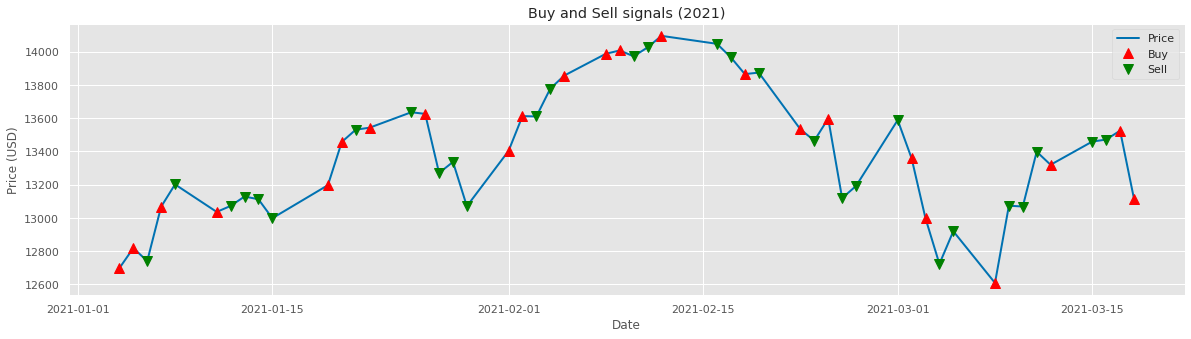

In [45]:
b = pd.concat([a.Close, df.nextDayDirection], 1)
b = b['2021-01-01':]

print(b.nextDayDirection.value_counts())
buys = b.loc[b["nextDayDirection"] == 1];
sells = b.loc[b["nextDayDirection"] == 0];
# Plot
fig = plt.figure(figsize=(20, 5));
plt.plot(b['Close'], lw=2., label='Price');
# Plot buy and sell signals
# up arrow when we buy one share
plt.plot(buys.index, b.loc[buys.index]['Close'], '^', markersize=10, color='red', lw=2., label='Buy');
# down arrow when we sell one share
plt.plot(sells.index, b.loc[sells.index]['Close'], 'v', markersize = 10, color='green', lw=2., label='Sell');
plt.ylabel('Price (USD)'); plt.xlabel('Date');
plt.title('Buy and Sell signals (2021)'); plt.legend(loc='best');
plt.grid(True)
plt.show()


In [46]:
# lags = 5
# # Create the shifted lag series of prior trading period close values
# for i in range(0, lags):
#     dataset["Lag%s" % str(i+1)] = dataset["Adj Close"].shift(i+1).pct_change()*100.0
# dataset['HL'] = (dataset['High'] - dataset['Close']) / dataset['Close'] * 100
# # creating more features
# dataset['returns'] = dataset['Adj Close'].pct_change() * 100
# dataset['vol_increment'] = dataset.Volume.diff() / dataset.Volume
# dataset.dropna(inplace=True)
# print(dataset.head()); print(dataset.shape)

### ***Target Variable***
This will be a classification variable, if the average price will go either up or down the next day.  The target will be forecasting the difference between today’s price and tomorrow’s price (which is unkonwn).

In [47]:
# #dataset['target'] = (dataset.Lag1.shift(-1) - dataset.Lag1)
# dataset['target'] = dataset['Close'].shift(-1)- dataset['Close']
# dataset.dropna(inplace=True)
# print(dataset.target); print()
# print('Total dataset has {} samples, and {} features.'.format(dataset.shape[0], dataset.shape[1]))

In [48]:
# corr = dataset.corr()
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

In [49]:
# # Checking Correlation 
# sns.set(style='darkgrid', context='talk', palette='Dark2')
# plt.figure(figsize=(14,5))
# dataset.corr()['target'].sort_values(ascending = False).plot(kind='bar')
# plt.show()

In [50]:
df.tail()

,closeGap,highGap,lowGap,volGap,dailyChange,nextDayDirection
Date,,,,,,
2021-03-12,-0.01,-0.01,-0.01,-0.08,0.01,1
2021-03-15,0.01,0.01,0.01,0.08,0.01,0
2021-03-16,0.00,0.01,0.01,-0.08,-0.00,0
2021-03-17,0.00,-0.00,-0.01,0.00,0.01,1
2021-03-18,-0.03,-0.02,-0.01,0.04,-0.02,1


In [51]:
def features():
    X = df.drop( columns = ['nextDayDirection'], axis=1)
    y = df.nextDayDirection
    return X,y
X,y = features()
print(X)

            closeGap  highGap  lowGap  volGap  dailyChange
Date                                                      
2010-01-05      0.00     0.00    0.00    0.23         0.00
2010-01-06     -0.00     0.00    0.00   -0.05        -0.00
2010-01-07     -0.00    -0.01   -0.00    0.01         0.00
2010-01-08      0.01     0.01    0.00   -0.05         0.01
2010-01-11     -0.00     0.00    0.01   -0.03        -0.01
...              ...      ...     ...     ...          ...
2021-03-12     -0.01    -0.01   -0.01   -0.08         0.01
2021-03-15      0.01     0.01    0.01    0.08         0.01
2021-03-16      0.00     0.01    0.01   -0.08        -0.00
2021-03-17      0.00    -0.00   -0.01    0.00         0.01
2021-03-18     -0.03    -0.02   -0.01    0.04        -0.02

[2820 rows x 5 columns]


In [52]:
print(y)

Date
2010-01-05    0
2010-01-06    0
2010-01-07    0
2010-01-08    0
2010-01-11    1
             ..
2021-03-12    1
2021-03-15    0
2021-03-16    0
2021-03-17    1
2021-03-18    1
Name: nextDayDirection, Length: 2820, dtype: int64


In [53]:
pip install tscv

In [54]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split, TimeSeriesSplit

from tscv import GapKFold
gkcv = GapKFold(n_splits=3, gap_before=2, gap_after=1)
#tscv = TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_samples, test_samples in gkcv.split(X):
  #print("TRAIN:", train_samples, "TEST:", test_samples)
  xTrain, xTest = X.values[train_samples], X.values[test_samples]
  yTrain, yTest = y[train_samples], y[test_samples]

# feature_names = ['Close','Open-Close', 'High-Low', 'Lag1', 'Lag2', 'returns', 'volIncrement']
# xTrain = pd.DataFrame(data=xTrain, columns=feature_names)
# xTest = pd.DataFrame(data=xTest, columns=feature_names)

print(xTrain.shape, yTrain.shape)
print(xTest.shape, yTest.shape)

# yTrain = pd.DataFrame(yTrain)
# yTrain.rename(columns = {0: 'target'}, inplace=True)

# yTest = pd.DataFrame(yTest)
# yTest.rename(columns = {0: 'target'}, inplace=True)

# def getBinary(val):
#     if val>0:
#         return 1
#     else:
#         return -1
# yTest_binary = pd.DataFrame(yTest["target"].apply(getBinary))
# print(yTest_binary)


(1878, 5) (1878,)
(940, 5) (940,)


In [55]:
len(xTrain)

1878

In [56]:
yTest

Date
2017-06-23    0
2017-06-26    0
2017-06-27    0
2017-06-28    1
2017-06-29    0
             ..
2021-03-12    1
2021-03-15    0
2021-03-16    0
2021-03-17    1
2021-03-18    1
Name: nextDayDirection, Length: 940, dtype: int64

The target variables will be transformed for binary classification. A positive change in the value of prices will be classified as 1 and a non-positive change as 0.

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

In [58]:
def MLModel():
  modelDT = DecisionTreeClassifier().fit(xTrain,yTrain)
  scoring = 'accuracy'
  cvResults = model_selection.cross_val_score(modelDT, xTrain, yTrain, cv=gkcv, scoring=scoring)
  accuracy =  (cvResults.mean(), cvResults.std())
  print(accuracy)
  return modelDT

modelDT = MLModel()
predict = pd.DataFrame(modelDT.predict(xTest))
predict.rename(columns ={0: 'predictedSignal'}, inplace=True)
print(predict.value_counts())
print(predict)

(0.5857294994675186, 0.0061639174136262865)


<IPython.core.display.Javascript object>

predictedSignal
0                  642
1                  298
dtype: int64
     predictedSignal
0                  1
1                  1
2                  0
3                  0
4                  0
..               ...
935                1
936                0
937                0
938                0
939                0

[940 rows x 1 columns]


In [81]:
z = dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
z = z.tail(len(xTest))
# print(z)

predict.index = z.index
# print(predict.tail())

pricesDf = pd.concat([z, predict],1)
pricesDf['predictedSignal'] = pricesDf['predictedSignal'].diff()
print(pricesDf.tail(15))

<IPython.core.display.Javascript object>

               Open     High      Low    Close      Volume  predictedSignal
Date                                                                       
2021-03-01 13406.16 13596.59 13362.66 13588.83  5047710000             0.00
2021-03-02 13599.45 13601.33 13352.00 13358.79  4920320000             1.00
2021-03-03 13336.25 13372.52 12995.07 12997.75  5493960000            -1.00
2021-03-04 12953.99 13068.71 12553.96 12723.47  7799710000             0.00
2021-03-05 12860.04 12941.21 12397.05 12920.15  7696900000             0.00
2021-03-08 12904.26 13001.00 12599.23 12609.16  5971260000             1.00
2021-03-09 12923.07 13151.54 12882.49 13073.82  6294910000             0.00
2021-03-10 13234.73 13277.11 13035.44 13068.83  5991730000            -1.00
2021-03-11 13273.31 13433.62 13246.33 13398.67  5956260000             1.00
2021-03-12 13222.81 13324.69 13158.72 13319.86  5472340000            -1.00
2021-03-15 13323.47 13460.35 13272.50 13459.71  5933440000             1.00
2021-03-16 1

In [ ]:
# regressor = xgb.XGBRegressor(objective ='reg:squarederror',
#                              gamma=0.0,
#                              n_estimators=200,
#                              base_score=0.7,
#                              colsample_bytree=1,
#                              learning_rate=0.01).fit(xTrain, yTrain)
# scores = cross_val_score(regressor, xTrain.values, yTrain.values, cv=gkcv)
# print("Training Accuracy (cross validated): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# scores = cross_val_score(regressor, xTest.values, yTest.values, cv=gkcv)
# print("Test Accuracy (cross validated): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


In [ ]:
# yPredicted = regressor.predict(xTest)
# yPredicted_binary = [1 if yp > 0 else -1 for yp in yPredicted]
# from sklearn.metrics import mean_squared_error
# print('RMSE: XGBoost', round(sqrt(mean_squared_error(yTest, yPredicted)),4))

In [ ]:
# model =  xgb.XGBRegressor(objective ='reg:squarederror',
#                              gamma=0.0,
#                              n_estimators=200,
#                              base_score=0.7,
#                              colsample_bytree=1,
#                              learning_rate=0.01).fit(X, y)
# Predict = model.predict(X)
# Predict_Binary = [1 if yp > 0 else -1 for yp in Predict]
# BinaryPredict = pd.DataFrame(Predict_Binary)
# BinaryPredict.rename({0 : 'Prediction'}, axis=1, inplace=True)
# BinaryPredict.index = dataset.index
# print(BinaryPredict) ; print()
# # number of trades over time for highest and second highest return strategy
# print('Number of trades = ', (BinaryPredict.Prediction.diff()!=0).sum())

In [ ]:
# db = dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
# prices = pd.concat([db, BinaryPredict],1)
# prices.rename(columns ={
#     'Prediction': 'predicted',
#     'Open':'open',
#     'High': 'high',
#     'Low': 'low',
#     'Close': 'close',
#     'Volume': 'volume'}, inplace=True)
# prices

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

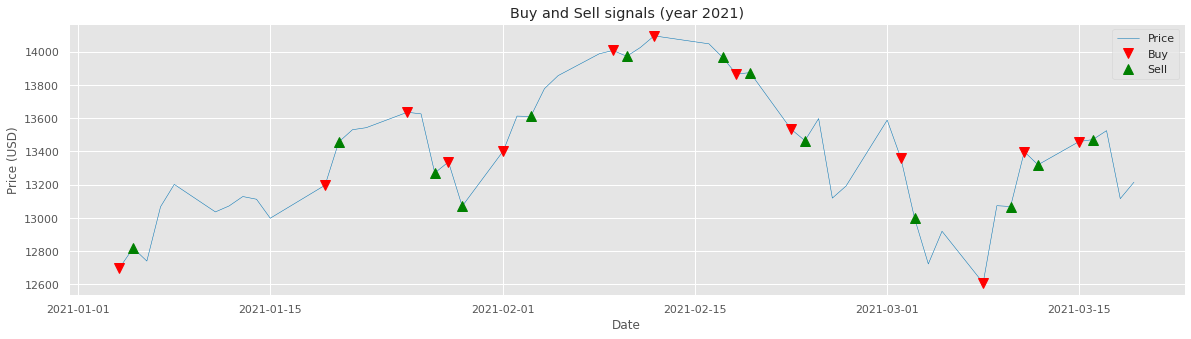

In [83]:
dd = pricesDf['2021-01-01':]
# Buy/Sell signals plot
sells = dd.loc[dd['predictedSignal'] == -1]; 
buys = dd.loc[dd['predictedSignal'] == 1];
# Plot
fig = plt.figure(figsize=(20, 5));
plt.plot(dd.index, dd['Close'], lw=.5, label='Price');
# Plot buy and sell signals

# up arrow when we buy one share
plt.plot(buys.index, dd.loc[buys.index]['Close'], 'v', markersize=10, color='red', lw=2., label='Buy');
# down arrow when we sell one share
plt.plot(sells.index, dd.loc[sells.index]['Close'], '^', markersize = 10, color='green', lw=2., label='Sell');
plt.ylabel('Price (USD)'); plt.xlabel('Date');
plt.title('Buy and Sell signals (year 2021)'); plt.legend(loc='best');
plt.show()

In [111]:
import sys, logging, json, pprint, requests

In [84]:

OHLCV = ['open', 'high', 'low', 'close', 'volume']

# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predictedSignal']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'Date': None})
    params = tuple(params.items())

Starting Portfolio Value: 15000.00
2017-07-06T00:00:00, BUY EXECUTED @ Price: 6109.60, Cost: 12219.20,Commission: 12.22
2017-07-10T00:00:00, SELL EXECUTED @ Price: 6156.03, Cost: 12219.20,Commission: 12.31
2017-07-11T00:00:00, BUY EXECUTED @ Price: 6171.25, Cost: 12342.50,Commission: 12.34
2017-07-12T00:00:00, SELL EXECUTED @ Price: 6238.90, Cost: 12342.50,Commission: 12.48
2017-07-14T00:00:00, BUY EXECUTED @ Price: 6289.08, Cost: 12578.16,Commission: 12.58
2017-07-17T00:00:00, SELL EXECUTED @ Price: 6320.35, Cost: 12578.16,Commission: 12.64
2017-07-24T00:00:00, BUY EXECUTED @ Price: 6387.82, Cost: 12775.64,Commission: 12.78
2017-07-26T00:00:00, SELL EXECUTED @ Price: 6425.93, Cost: 12775.64,Commission: 12.85
2017-07-31T00:00:00, BUY EXECUTED @ Price: 6394.69, Cost: 12789.38,Commission: 12.79
2017-08-01T00:00:00, SELL EXECUTED @ Price: 6372.16, Cost: 12789.38,Commission: 12.74
2017-08-04T00:00:00, BUY EXECUTED @ Price: 6350.79, Cost: 12701.58,Commission: 12.70
2017-08-08T00:00:00, SELL

<IPython.core.display.Javascript object>

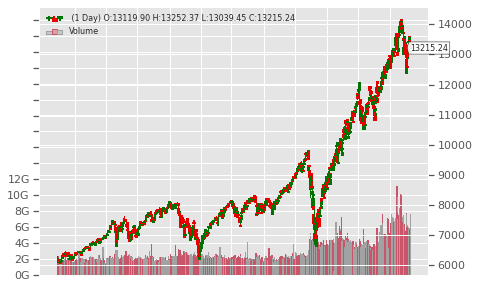

In [160]:
# define backtesting strategy class
class businessStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predictedSignal
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        self.data_volume = self.datas[0].volume
        
        # # keep track of pending orders/buy price/buy commission
        # self.order = None
        # self.price = None
        # self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.datetime(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED @ Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED @ Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
    def next_open(self):
        if not self.position:
            if self.data_predicted == 1:
                size = int(self.broker.getcash() / self.datas[0].open)
                self.buy(size=size)
        else:
            if self.data_predicted == -1:
                self.sell(size=self.position.size)

# instantiate SignalData class
data = SignalData(dataname=pricesDf)

# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
strategyEvaluation = bt.Cerebro(stdstats = False, cheat_on_open=True)
strategyEvaluation.addstrategy(businessStrategy)
strategyEvaluation.adddata(data)
strategyEvaluation.broker.setcash(15000.0)
strategyEvaluation.broker.setcommission(commission=0.001)
strategyEvaluation.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# run the backtest
print('Starting Portfolio Value: %.2f' % strategyEvaluation.broker.getvalue())
backtest_result = strategyEvaluation.run()
print('Final Portfolio Value: %.2f' % strategyEvaluation.broker.getvalue())
strategyEvaluation.broker.set_coc(True)
strategyEvaluation.plot(style='candlestick', barup='green', bardown='red',
                subtxtsize=8)[0][0].savefig('samplefigure.png', dpi=300)

In [151]:
dataset['returns'] = dataset['Adj Close'].pct_change()

In [152]:
dataset['returns'] = dataset['Adj Close'].pct_change()

# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
#returns.tail()

# benchmark returns
benchmark_rets = dataset['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nasdaq Composite'
#benchmark_rets.tail()

# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2017-06-26
End date,2021-03-19
Total months,44
,Backtest
Annual return,2.8%
Cumulative returns,10.7%
Annual volatility,10.5%
Sharpe ratio,0.31
Calmar ratio,0.24
Stability,0.64
Max drawdown,-11.6%


In [153]:
# get performance statistics for benchmark
pf.show_perf_stats(benchmark_rets)

Start date,2017-06-26
End date,2021-03-19
Total months,44
,Backtest
Annual return,22.2%
Cumulative returns,110.9%
Annual volatility,23.9%
Sharpe ratio,0.96
Calmar ratio,0.74
Stability,0.81
Max drawdown,-30.1%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

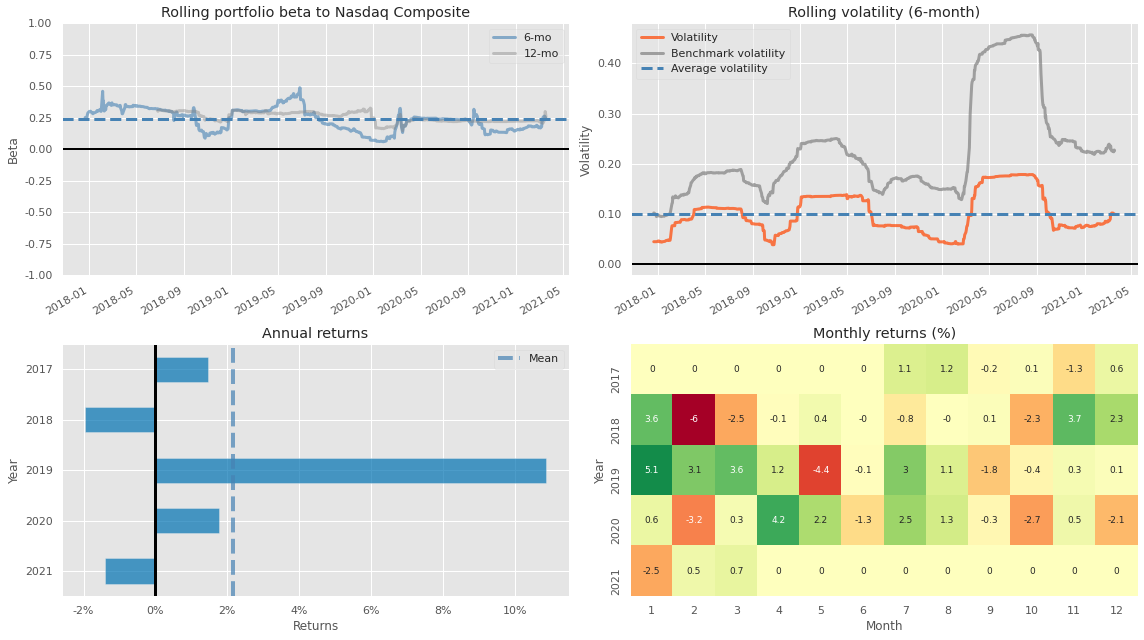

In [154]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)
pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
plt.tight_layout()